# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split , GridSearchCV  , cross_val_score
from sklearn.preprocessing import RobustScaler , OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import f1_score ,classification_report , confusion_matrix , balanced_accuracy_score , roc_curve , roc_auc_score , recall_score , precision_score

import pickle

import warnings 
warnings.filterwarnings(action="ignore")
plt.rcParams["figure.figsize"] = (12,8)

# Importing Dataset

In [2]:
data = pd.read_csv("income_evaluation.csv")
df = data.copy()
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Checking null values and visuualize it with heatmap

In [3]:
df.isnull().sum()

age                0
 workclass         0
 fnlwgt            0
 education         0
 education-num     0
 marital-status    0
 occupation        0
 relationship      0
 race              0
 sex               0
 capital-gain      0
 capital-loss      0
 hours-per-week    0
 native-country    0
 income            0
dtype: int64

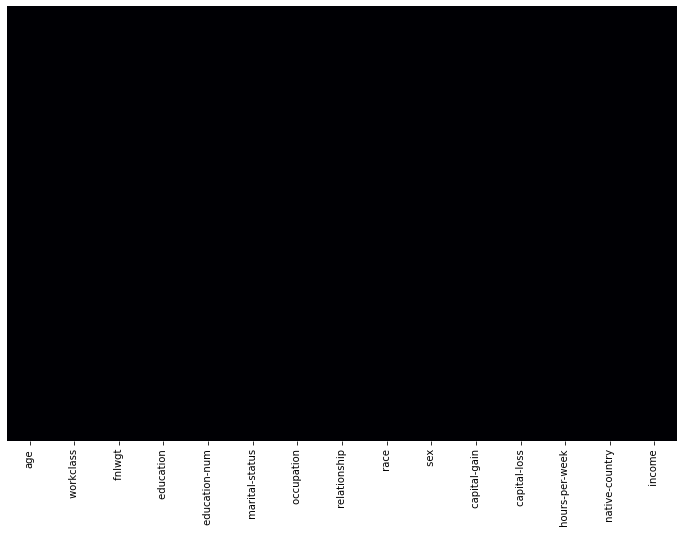

In [4]:
sns.heatmap(data = df.isnull() , cmap = "magma" , cbar = False , yticklabels=False)
plt.show()

# First I have cheacked that if there are duplicates in the dataset or not. Then I have applyed drop_duplicates function 

In [5]:
print("Before there are {} duplicates in the dataset".format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)
print("After there are {} duplicates in the dataset".format(df.duplicated().sum()))

Before there are 24 duplicates in the dataset
After there are 0 duplicates in the dataset


# I have droped all blank spaces in the columns, also in the whole dataset then capitlize the columns

In [6]:
df.columns = df.columns.str.strip()
df.rename(columns = lambda x : str(x).capitalize() , inplace = True)
for x in df.select_dtypes(exclude="number").columns.to_list() : 
    df[x] = df[x].str.strip()

# Converting "?" to "NaN" values

In [7]:
df = df.replace("?" , np.nan).replace(" ?" , np.nan)

In [8]:
df.isnull().sum()

Age                  0
Workclass         1836
Fnlwgt               0
Education            0
Education-num        0
Marital-status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital-gain         0
Capital-loss         0
Hours-per-week       0
Native-country     582
Income               0
dtype: int64

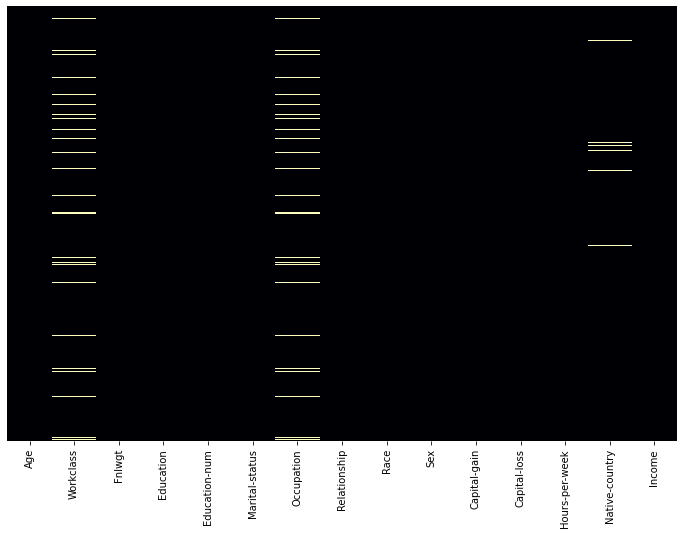

In [9]:
sns.heatmap(data = df.isnull() , cbar = False , cmap="magma" , yticklabels=False)
plt.show()
# I will ipmute the missing values with the help of the Simpleimputer inside the Pipeline

# Replace all countries without United States as "others"

In [10]:
df["Native-country"].value_counts(normalize=True)
# 91 % percent of the Native-country variable is United states. Thats why I replaced all other countries as "Others".

United-States                 0.912314
Mexico                        0.019997
Philippines                   0.006196
Germany                       0.004287
Canada                        0.003787
Puerto-Rico                   0.003568
El-Salvador                   0.003317
India                         0.003129
Cuba                          0.002973
England                       0.002816
Jamaica                       0.002535
South                         0.002504
China                         0.002347
Italy                         0.002284
Dominican-Republic            0.002191
Vietnam                       0.002097
Japan                         0.001940
Guatemala                     0.001940
Poland                        0.001878
Columbia                      0.001846
Taiwan                        0.001596
Haiti                         0.001377
Iran                          0.001346
Portugal                      0.001158
Nicaragua                     0.001064
Peru                     

In [11]:
df.loc[df["Native-country"] != "United-States" , "Native-country"] = "Others"
df["Native-country"].value_counts(normalize = True)

United-States    0.895995
Others           0.104005
Name: Native-country, dtype: float64

In [12]:
df.drop(columns=["Fnlwgt"] , inplace = True)
# Fnlwgt columns is like as a ID columns. So it is not important variable for our model.That's why I have dropped it

# I have changed <=50k as 1 So i will predict 1 (if income is less than 50k)

In [13]:
df["Income"] = df["Income"].map({"<=50K" : 1 , ">50K" : 0})

In [14]:
df.head()

,Age,Workclass,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,1
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,1
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,1
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,1
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Others,1


# Correlations between variables of Dataset

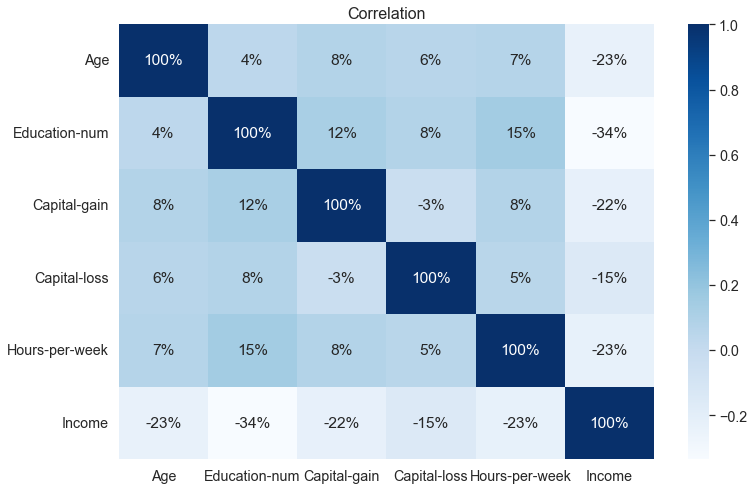

In [15]:
sns.set(style = "darkgrid" , font_scale = 1.3 , palette = "bright")
sns.heatmap(data = df.corr() , cmap = plt.cm.Blues , cbar = True , annot = True , fmt = ".0%")
plt.title("Correlation" , fontsize = 16)
plt.show()

# Spliting dateset to X and y

In [16]:
X = df.drop(columns = ["Income"])
y = df["Income"]

# Visualization for our predicted variable(dependent) and checked if the values of the outcome are balanced or not

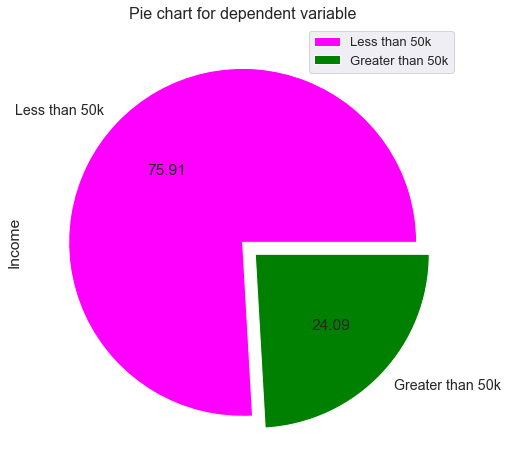

In [17]:
y.value_counts().plot(kind = "pie" , autopct = "%.2f" , explode = [0.0 , 0.1] , colors = ["magenta" , "green"] , labels = ["Less than 50k" , "Greater than 50k"])
plt.title("Pie chart for dependent variable" , fontsize = 16)
plt.legend(loc = "best" , fontsize = 13)
plt.show()

# Spliting DataSet to train and test

In [18]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42 , stratify=y)

# I have grouped all types of variables as list for pipeline

In [19]:
numeric = ["Age" , "Capital-gain" , "Capital-loss" , "Hours-per-week"]
categoric = ["Workclass" , "Marital-status" , "Education" , "Occupation" , "Relationship" , "Race" , "Native-country" , "Sex"]
ordinal_binary = ["Education-num"]

# Creating pipelines for each types of variable

In [20]:
pipe_numeric = make_pipeline((SimpleImputer(missing_values=np.nan , strategy="median")) , (RobustScaler()))
pipe_categoric = make_pipeline((SimpleImputer(missing_values=np.nan , strategy="most_frequent")) , (OneHotEncoder(handle_unknown="ignore")))
pipe_ordinal = make_pipeline((SimpleImputer(missing_values=np.nan , strategy="most_frequent")))

# Applying pipelines to the dateset with the help of the make_column_tranformer

In [21]:
transformer = make_column_transformer((pipe_numeric , numeric),
                                      (pipe_categoric , categoric),
                                      (pipe_ordinal , ordinal_binary))

# Automate score, metrics, cross validation, confussion matrix, roc_curve with the help of the functions

In [22]:
def score_function(model_name) : 
    train_score = model_name.score(X_train , y_train)
    test_score = model_name.score(X_test , y_test)
    
    print("The train score is {:.2%}".format(train_score))
    print("The test score is {:.2%}".format(test_score))

In [23]:
def threshold_method(model_name) : 
    recall_scores =  [recall_score(y_true = y_test, y_pred = np.where(model_name.predict_proba(X = X_test)[:, 1] >= proba, 1, 0), pos_label = 0) for proba \
    in np.arange(start = 0.0, stop = 1.01, step = 0.01)]
    precision_scores =  [precision_score(y_true = y_test, y_pred = np.where(model_name.predict_proba(X = X_test)[:, 1] >= proba, 1, 0), pos_label = 0) for proba \
    in np.arange(start = 0.0, stop = 1.01, step = 0.01)]
    plt.plot(np.arange(start = 0.0, stop = 1.01, step = 0.01), recall_scores, label = 'Negative Recall Score', c = 'darkorange')
    plt.plot(np.arange(start = 0.0, stop = 1.01, step = 0.01), precision_scores, label = 'Negative Precision Score', c = 'teal')
    plt.title(label = 'Thresholding for Negative Recall & Precision Score', fontsize = 16)
    plt.axvline(0.5, label = 'Default Threshold', c = 'grey')
    plt.ylabel(ylabel = 'Negative Recall & Precision Score', fontsize = 16)
    plt.xlabel(xlabel = 'Probabilities', fontsize = 16)
    plt.legend(loc = 'best', fontsize = 16)
    plt.grid()
    plt.show()


In [24]:
def metrics_function(model_name) : 
    roc = roc_auc_score(y_test ,y_pred)
    gini = (2*roc)-1
    f1 = f1_score(y_test ,y_pred)
    balance = balanced_accuracy_score(y_test , y_pred)
    
    print("AUC score : {:.2%}".format(roc))
    print("Gini score : {:.2%}".format(gini))
    print("F1 score  : {:.2%}".format(f1))
    print("Balance accuracy score {:.2%}".format(balance))

In [25]:
def cross_function(model_name) :
    cr = cross_val_score(estimator=model_name , X = X_train , y = y_train , scoring="accuracy" , cv = 10 , n_jobs=-1)
    
    max_score = np.argmax(cr)
    min_score = np.argmin(cr)
    mean_score = np.mean(cr)
    
    print("The maxsimum score for this model can be {:.2%}".format(cr[max_score]))
    print("The minumum score for this model can be {:.2%}".format(cr[min_score]))
    print("The mean of the cross validation is {:.2%}".format(mean_score))

In [26]:
def confussion_function(model_name) : 
    cm = confusion_matrix(y_test , y_pred)
    sns.heatmap(data = cm , cbar = False , yticklabels=False , xticklabels=False, annot = True , fmt = ".5g" , cmap = plt.cm.Blues)
    plt.title("The Confussion Matrix" , fontsize = 16)
    plt.ylabel("Ground Truth" , fontsize = 16)
    plt.xlabel("Predictions" , fontsize = 16)
    plt.show()

In [28]:
def roc_cruve_function(model_name) : 
    
    fpr , tpr , _ = roc_curve(y_true = y_test , y_score = model_name.predict_proba(X_test)[: , 1])
    plt.plot(fpr , tpr , label = "Our Model" , color = "magenta")
    plt.plot([0,1] , [0,1] , label = "Random Model")
    plt.title("Roc Curve" , fontsize = 16)
    plt.ylabel("True Positive Rate" , fontsize = 16)
    plt.xlabel("False Positive Rage" , fontsize = 16)

# Logistic Regression

In [29]:
model_log = make_pipeline(transformer , 
                                SequentialFeatureSelector(estimator=LogisticRegression() , scoring="accuracy" , cv = 5 , n_jobs=-1),
                                LogisticRegression())
model_log.fit(X_train , y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Capital-gain',
                                                   'Capital-loss',
                                                   'Hours-per-week']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot

# Train and Test score

In [30]:
score_function(model_name = model_log)

The train score is 84.14%
The test score is 84.14%


# Applying threshold method for to balance recall and precission

In [31]:
y_pred = model_log.predict(X_test)

In [32]:
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.72      0.56      0.63      1568
           1       0.87      0.93      0.90      4940

    accuracy                           0.84      6508
   macro avg       0.79      0.75      0.76      6508
weighted avg       0.83      0.84      0.83      6508



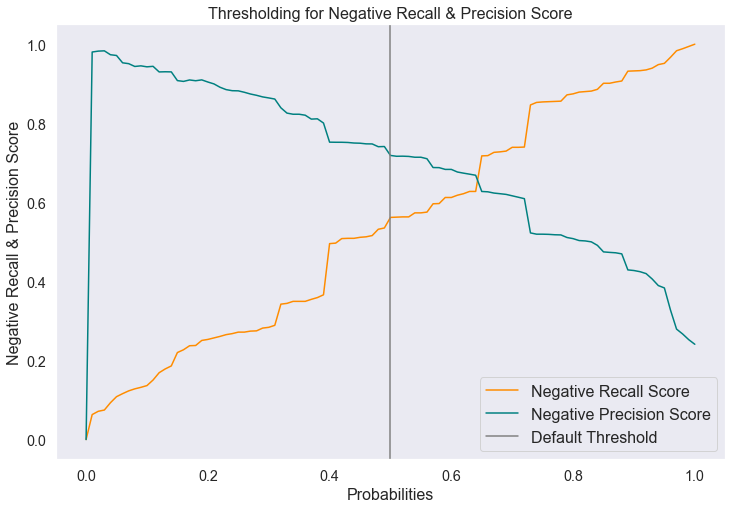

In [33]:
threshold_method(model_name=model_log)

In [38]:
# According to the plot the balance threshold is 65
y_pred = np.where(model_log.predict_proba(X_test)[: , 1] > 0.65 , 1, 0)
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1568
           1       0.91      0.86      0.88      4940

    accuracy                           0.83      6508
   macro avg       0.77      0.79      0.78      6508
weighted avg       0.84      0.83      0.83      6508



# Metrics for Logistic Regression

In [39]:
metrics_function(model_name=model_log)

AUC score : 79.11%
Gini score : 58.23%
F1 score  : 88.49%
Balance accuracy score 79.11%


# Cross Validation for Logistic Regression

In [40]:
cross_function(model_name = model_log)

The maxsimum score for this model can be 85.21%
The minumum score for this model can be 80.56%
The mean of the cross validation is 83.95%


# Confussion Matrix for Logistic Regression

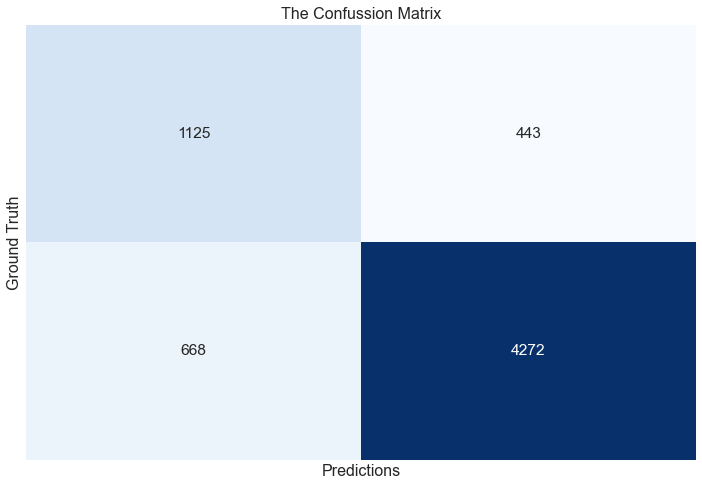

In [41]:
confussion_function(model_name = model_log)

# Roc Curve for Logistic Regression

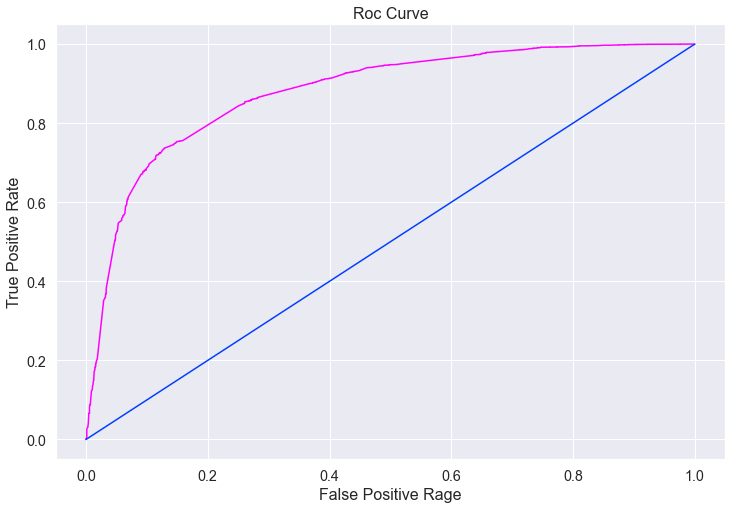

In [45]:
roc_cruve_function(model_name = model_log)

# KNeighbors

In [46]:
from sklearn.neighbors import KNeighborsClassifier

In [47]:
model_kn = make_pipeline(transformer , KNeighborsClassifier())
model_kn.fit(X_train , y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Capital-gain',
                                                   'Capital-loss',
                                                   'Hours-per-week']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot

# Parameters for Kneighbors

In [53]:
KNeighborsClassifier()
parametrs_kn = {"kneighborsclassifier__n_neighbors" : [0,1,2,3,4,5,6,7,8,9] , "kneighborsclassifier__weights" : ["uniform" , "distance"] , 
                "kneighborsclassifier__leaf_size" : [27,28,29,30,31,32,33],
                "kneighborsclassifier__p" : [0,1,2,3,4,5]}

# Creating hyperparametr tuning for Kneigbirs

In [54]:
hyper_model = GridSearchCV(estimator=model_kn , param_grid=parametrs_kn , scoring="accuracy" , n_jobs=-1 , cv = 5)
hyper_model.fit(X_train , y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['Age',
                                                                          'Capital-gain',
                                                                          'Capital-loss',
                                                                          'Hours-per-week']),
                               

# Applying best_estimator parametr to variable as our new model

In [55]:
kn_model = hyper_model.best_estimator_

# Train and Test score

In [56]:
score_function(model_name=kn_model)

The train score is 88.62%
The test score is 86.22%


# Applying threshold method for to balance recall and precission

In [57]:
y_pred = kn_model.predict(X_test)
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70      1568
           1       0.90      0.92      0.91      4940

    accuracy                           0.86      6508
   macro avg       0.82      0.80      0.81      6508
weighted avg       0.86      0.86      0.86      6508



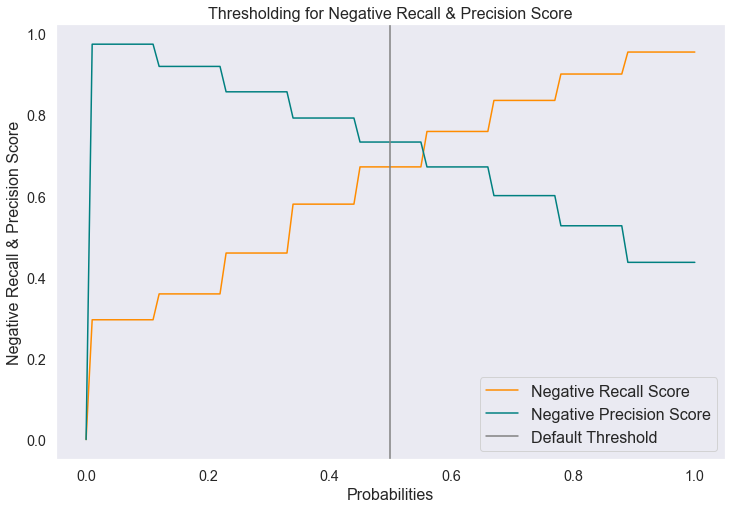

In [58]:
threshold_method(model_name=kn_model)

In [62]:
# According to the plot the balace threshold is 59
y_pred = np.where(kn_model.predict_proba(X_test)[:, 1]>0.59 ,1 ,0)
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71      1568
           1       0.92      0.88      0.90      4940

    accuracy                           0.85      6508
   macro avg       0.80      0.82      0.81      6508
weighted avg       0.86      0.85      0.86      6508



# Metrics for KNeighbors

In [63]:
metrics_function(model_name=kn_model)

AUC score : 82.10%
Gini score : 64.20%
F1 score  : 90.10%
Balance accuracy score 82.10%


# Cross Validation for KNeighbors

In [65]:
cross_function(model_name=kn_model)

The maxsimum score for this model can be 87.55%
The minumum score for this model can be 85.56%
The mean of the cross validation is 86.37%


# Confussion Matrix for KNeighbors

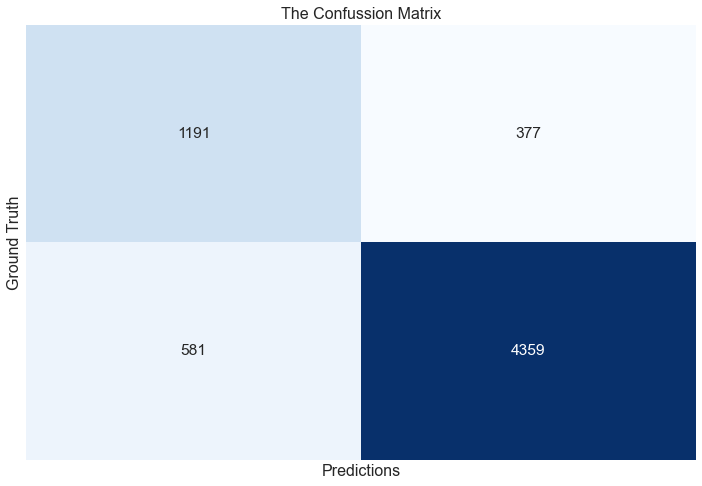

In [66]:
confussion_function(model_name=kn_model)

# Roc Curve for KNeighbors

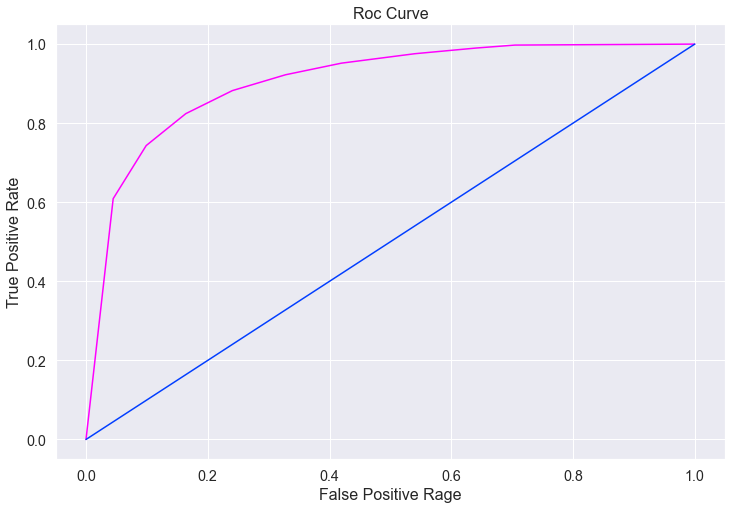

In [67]:
roc_cruve_function(model_name=kn_model)

# XGBClassifier 

In [68]:
from xgboost import XGBClassifier
model_xg = make_pipeline(transformer , XGBClassifier())
model_xg.fit(X_train , y_train)

[13:54:12] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Capital-gain',
                                                   'Capital-loss',
                                                   'Hours-per-week']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot

# Train and Test scores

In [71]:
score_function(model_name=model_xg)

The train score is 89.47%
The test score is 87.06%


# Applying threshold method for to balance recall and precission

In [72]:
y_pred = model_xg.predict(X_test)
print(classification_report(y_test  ,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.66      0.71      1568
           1       0.90      0.94      0.92      4940

    accuracy                           0.87      6508
   macro avg       0.83      0.80      0.81      6508
weighted avg       0.87      0.87      0.87      6508



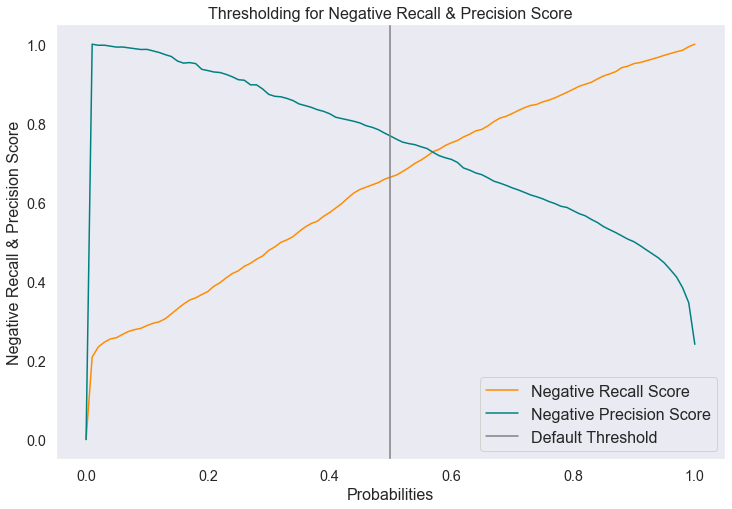

In [73]:
threshold_method(model_name=model_xg)

In [80]:
# According to the plot the balace threshold is 0.58
y_pred = np.where(model_xg.predict_proba(X_test)[: , 1] >= 0.58 , 1, 0)
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.72      0.73      0.73      1568
           1       0.91      0.91      0.91      4940

    accuracy                           0.87      6508
   macro avg       0.82      0.82      0.82      6508
weighted avg       0.87      0.87      0.87      6508



# Metrics for XGBClassifier

In [81]:
metrics_function(model_name=model_xg)

AUC score : 82.13%
Gini score : 64.26%
F1 score  : 91.17%
Balance accuracy score 82.13%


# Confussion Matrix for XGBClassifier

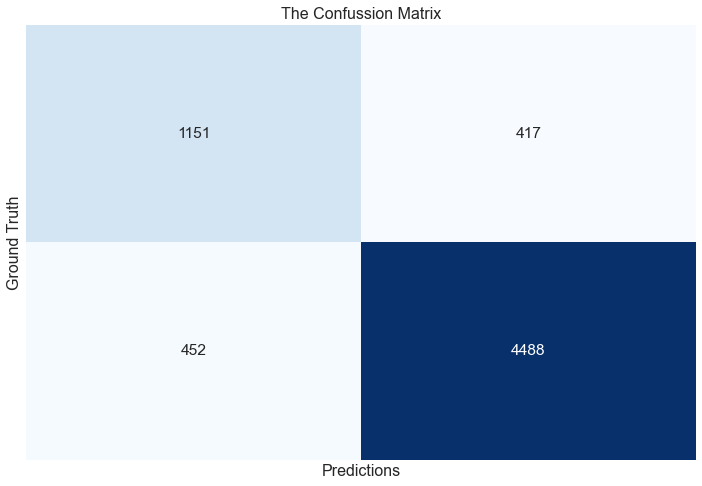

In [82]:
confussion_function(model_name=model_xg)

# Roc Curve for XGBClassifier

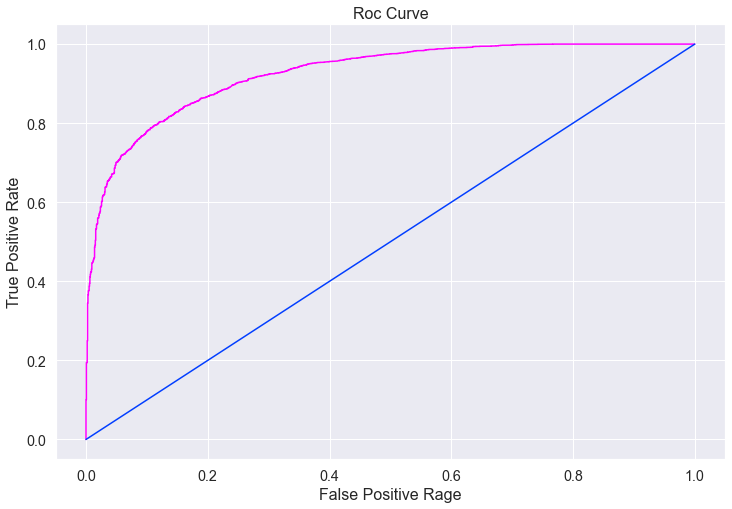

In [83]:
roc_cruve_function(model_name=model_xg)

# Saving our model with pickle

In [84]:
file_name = "MoneyProject"
pickle.dump(model_xg , open(file_name , "wb"))

# Saving our X_test for predictions on Streamlit application

In [85]:
X_test.to_csv("Money_X_test_project" , index = False)